In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv', index_col='index')

In [3]:
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)
train.fillna('BaekSu', inplace=True) 

test.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test.fillna('BaekSu', inplace=True)


In [4]:
train = train[train['family_size'] <= 7]

In [5]:
train.set_index('index', inplace=True)
train = train.reset_index(drop=True)

In [6]:
# train.loc[(train.income_type=='Student'), 'income_type'] = 'Pensioner'
# test.loc[(test.income_type=='Student'), 'income_type'] = 'Pensioner'

In [7]:
# train["DAYS_EMPLOYED"][train["DAYS_EMPLOYED"] >0] = train["DAYS_EMPLOYED"][train["DAYS_EMPLOYED"] >0].replace(365243, 0)
# train["DAYS_EMPLOYED"][train["DAYS_EMPLOYED"] >0]

# test["DAYS_EMPLOYED"][test["DAYS_EMPLOYED"] >0] = test["DAYS_EMPLOYED"][test["DAYS_EMPLOYED"] >0].replace(365243, 0)
# test["DAYS_EMPLOYED"][test["DAYS_EMPLOYED"] >0]

In [8]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=-train[feat]
    test[feat]=-test[feat]

In [9]:
# train_corr = train.corr()
# ax = plt.subplots(figsize=(30, 25))
# ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

In [10]:
for df in [train,test]:
    df['DAYS_BIRTH_DAYS_EMPLOYED_ratio'] = df['DAYS_BIRTH'] / df['DAYS_EMPLOYED']
    df['income_total_DAYS_BIRTH_ratio'] = df['income_total'] / df['DAYS_BIRTH']
    df['income_total_DAYS_EMPLOYED_ratio'] = df['income_total'] / df['DAYS_EMPLOYED']
    df['parents'] = df['family_size'] - df['child_num']
    Workingdays = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_workingday_ratio'] = df['income_total'] / Workingdays
    #df['income_total_family_size_ratio'] = df['income_total'] / df['family_size']

In [11]:
le = LabelEncoder()
for df in [train,test]:
    df['gender'] = le.fit_transform(df['gender'].astype(str))
    df['car'] = le.fit_transform(df['car'].astype(str))
    df['reality'] = le.fit_transform(df['reality'].astype(str))
    df['income_type'] = le.fit_transform(df['income_type'].astype(str))
    df['edu_type'] = le.fit_transform(df['edu_type'].astype(str))
    df['family_type'] = le.fit_transform(df['family_type'].astype(str))
    df['house_type'] = le.fit_transform(df['house_type'].astype(str))
    df['family_type'] = le.fit_transform(df['family_type'].astype(str))
    df['occyp_type'] = le.fit_transform(df['occyp_type'].astype(str))

In [12]:
# train_corr = train.corr()
# ax = plt.subplots(figsize=(30, 25))
# ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

### ID생성 / 중복컬럼 제거

In [13]:
train['ID'] = \
train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

test['ID'] = \
test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

In [14]:
#ID : 기존에 있는 아이디면 그대로 인코딩, 없으면 -1로 인코딩
le = LabelEncoder()
train['ID'] = le.fit_transform(train['ID'])
test.loc[~test['ID'].isin(le.classes_),'ID'] = -1
test.loc[test['ID'].isin(le.classes_),'ID'] = le.transform(test['ID'][test['ID'].isin(le.classes_)])

In [15]:
test = test.astype({'ID': 'int32'})

In [16]:
# target = 'credit'
# income_type_mean = train.groupby('income_type')[target].mean()
# train['income_type_mean'] = train['income_type'].map(income_type_mean)
# test['income_type_mean'] = test['income_type'].map(income_type_mean)

In [17]:
# open_month = pd.DataFrame(train.groupby('ID')['begin_month'].min(), index=train.groupby('ID')['begin_month'].min().index)
# open_month= open_month.astype('int')
# open_month.columns = ['open_month']
# om_dict = open_month.open_month.to_dict()

# train['open_month'] = train["ID"]
# train['open_month'] = train['open_month'].map(om_dict)

In [18]:
# open_month = pd.DataFrame(test.groupby('ID')['begin_month'].min(), index=test.groupby('ID')['begin_month'].min().index)
# open_month= open_month.astype('int')
# open_month.columns = ['open_month']
# om_dict = open_month.open_month.to_dict()

# test['open_month'] = test["ID"]
# test['open_month'] = test['open_month'].map(om_dict)

In [19]:
#train.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)
#test.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)

In [20]:
#train.drop(['ID'], axis=1, inplace=True)
#test.drop(['ID'], axis=1, inplace=True)

In [21]:
#new_data=pd.DataFrame(train.groupby(["ID"])["begin_month"].agg(min))
#new_data

In [22]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
# numerical_feats.remove('ID')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

total_feats = numerical_feats + categorical_feats

Number of Numerical features:  23
Number of Categorical features:  0


## LabelEncoding, Scaling

In [23]:
# for feat in categorical_feats:
#     encoder = LabelEncoder()
#     train[feat] = encoder.fit_transform(train[feat])
#     test[feat] = encoder.transform(test[feat])

In [24]:
# for col in ['family_size', 'child_num']:
#     train[col] = np.log2(1 + train[col])
#     test[col] = np.log2(1 + test[col])

# feats = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

# scaler = MinMaxScaler()
# train[['DAYS_EMPLOYED']] = scaler.fit_transform(train[['DAYS_EMPLOYED']])
# test[['DAYS_EMPLOYED']] = scaler.transform(test[['DAYS_EMPLOYED']])


## Modeling

In [25]:
n_est = 1000
seed = 42
n_fold = 5
n_class = 3

rf_params = {
    'max_depth': 16,
    'min_samples_leaf': 8,
    'random_state': seed
}

# lgb_params = {
#     'metric': 'multi_logloss',
#     'n_estimators': n_est,
#     'objective': 'multiclass',
#     'random_state': seed,
#     'learning_rate': 0.01,
#     'min_child_samples': 20,
#     'reg_alpha': 3e-5,
#     'reg_lambda': 9e-2,
#     'num_leaves': 127,
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'num_class': n_class,
#     'early_stopping_rounds':500,
#     'n_jobs':-1,
#     'max_depth':-1,
# }

lgb_params = {
                    'objective':'multiclass',
                    'num_class': 3,
                    'boosting_type':'gbdt',
                    'metric':'multi_logloss',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 127,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    "min_child_weight": 0.01,
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':1000,
                    'max_bin':800,
                    'verbose':-1,
                    'seed': seed,
                    #'early_stopping_rounds':300, 
                }

In [26]:
models = {'RF': RandomForestClassifier(**rf_params), 
               'LGBM': LGBMClassifier(**lgb_params),
}

In [27]:
X = train.drop('credit', axis=1)
y = train['credit']
X_test = test

In [ ]:
target = 'credit'

In [ ]:
train8, train2 = train_test_split(train, test_size=0.2, random_state=seed)

In [ ]:
remove_features = []
remove_features += ['index' , 'credit']
features = [col for col in list(train) if col not in remove_features]
#features

In [ ]:
old_score=0
features_columns = [col for col in list(train8) if col not in remove_features]
X_train, y_train = train8[features_columns], train8[target]    
X_val, y_val = train2[features_columns], train2[target]
    
tt_df = train2[['index',target]]        
y_preds = np.zeros((train2.shape[0],n_class))
test_preds = np.zeros((X_test.shape[0], n_class))


tr_data = lgb.Dataset(X_train, label=y_train)
vl_data = lgb.Dataset(X_val, label=y_val) 
estimator = lgb.train(
        lgb_params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 100,
        )
y_preds += estimator.predict(X_val)

test_preds += estimator.predict(X_test)
feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X_train.columns)), columns=['Value','Feature'])
     
m_results = []
print('#'*20)
  
g_logloss = log_loss(tt_df[target], y_preds)
score_diff = g_logloss - old_score
print('Global log loss', g_logloss)
m_results.append(g_logloss)
    
print('#'*20)
print('Features Preformance:', g_logloss)
print('Diff with previous__:', score_diff)

### fold

In [ ]:
# old_score=0
    
# y_preds = np.zeros((X.shape[0],n_class))
# test_preds = np.zeros((X_test.shape[0], n_class))
    
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
#     tr_data = lgb.Dataset(X.iloc[i_trn], label=y.iloc[i_trn])
#     #vl_data = lgb.Dataset(X_val.iloc[i_trn], label=y_val.iloc[i_trn]) 
#     estimator = lgb.train(
#             lgb_params,
#             tr_data,
#             #valid_sets = [tr_data, vl_data],
#             verbose_eval = 100,
#         )
#     y_preds[i_val] = estimator.predict(X.iloc[i_val])

#     test_preds += estimator.predict(X_test) / n_fold
    
# skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# folds=[]
# for train_idx, valid_idx in skfold.split(X, y):
#         folds.append((train_idx, valid_idx))
# for fold in range(5):
#     train_idx, valid_idx = folds[fold]
#     X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
#     tr_data = lgb.Dataset(X.iloc[i_trn], label=y.iloc[i_trn])
#     estimator = lgb.train(
#             lgb_params,
#             tr_data,
#             #valid_sets = [tr_data, vl_data],
#             verbose_eval = 100,
#         )
#     pred[valid_idx] = models[name].predict_proba(X_valid)
#     pred_test += models[name].predict_proba(X_test) / 5

In [ ]:
# feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
     
# m_results = []
# print('#'*20)
  
# g_logloss = log_loss(y, y_preds)
# score_diff = g_logloss - old_score
# print('Global log loss', g_logloss)
# m_results.append(g_logloss)
    
# print('#'*20)
# print('Features Preformance:', g_logloss)
# print('Diff with previous__:', score_diff)

In [ ]:
# test_preds

In [ ]:
# pred_df = pd.DataFrame(data=test_preds)
# pred_df

# sub = pd.read_csv('sample_submission.csv', index_col='index')
# sub[sub.columns] = pred_df.values
# sub.to_csv('submission0501_featim2.csv')

In [28]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

pred_dic = {}
pred_test_dic = {}
        
for name in models:
    print(f'Training {name}:')
    pred = np.zeros((X.shape[0], 3), dtype=float)
    pred_test = np.zeros((X_test.shape[0], 3), dtype=float)
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        models[name].fit(X_train, y_train)
        pred[valid_idx] = models[name].predict_proba(X_valid)
        pred_test += models[name].predict_proba(X_test) / 5
        
    pred_dic[name] = pred
    pred_test_dic[name] = pred_test
    print(f'\tCV Log Loss: {log_loss(y, pred):.6f}')

Training RF:
	CV Log Loss: 0.749373
Training LGBM:
	CV Log Loss: 0.708569


In [ ]:
best_score_(models['LGBM'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

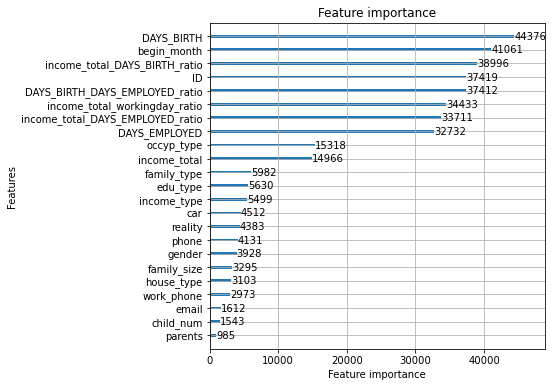

In [29]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(6, 6))
plot_importance(models['LGBM'], ax=ax)

In [30]:
pred_df = pd.DataFrame(data=pred_test_dic['LGBM'])
pred_df

sub = pd.read_csv('sample_submission.csv', index_col='index')
sub[sub.columns] = pred_df.values
sub.to_csv('submission0501_origin_model.csv')

### Stacking
ref)https://dacon.io/codeshare/1828?dtype=recent

In [ ]:
X_train7 , X_val3, y_train7, y_val3 = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import StackingClassifier

clf1 = RandomForestClassifier()
clf2 = SVC(probability=True)
clf3 = LogisticRegression(multi_class = 'ovr')

In [ ]:
clf = StackingClassifier(estimators=[('rf', clf1), ('svc', clf2), ('lr', clf3)], #모델 합치기
    final_estimator=models['LGBM'], n_jobs = -1, stack_method = 'predict_proba', cv = 5)

In [ ]:
clf = clf.fit(X_train7, y_train7)

In [ ]:
y_pred_stack = clf.predict_proba(X_val3)

In [ ]:
    print(f'\tCV Log Loss: {log_loss(y_val3, y_pred_stack):.6f}')

In [ ]:
pred_df = pd.DataFrame(data=y_pred_stack)
pred_df

In [ ]:
sub = pd.read_csv('sample_submission.csv', index_col='index')
sub[sub.columns] = pred_df.values
sub.to_csv('submission0428_stacking.csv')